# Image classification 

Image classification is a computer vision task that involves categorizing images into predefined classes or categories. The goal is to develop algorithms or models that can accurately identify and assign labels to images based on their visual features and content. This task is commonly used in various applications, such as object recognition, facial recognition, medical imaging, and autonomous driving, to enable machines to understand and interpret visual information in a similar way to humans. The output of an image classification task is a prediction or probability distribution indicating the likelihood of each class for a given image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import time, copy

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data.dataset import random_split


from quantum_circuit_simulator import quantum_circuit


## Load dataset and transform

The "Modified National Institute of Standards and Technology" (__MNIST__) dataset consists of a large collection of 60,000 handwritten digits for training and an additional 10,000 handwritten digits for testing.
It dataset has served as a benchmark for evaluating and comparing the performance of various machine learning algorithms, particularly in the field of image classification. It has played a crucial role in the development and advancement of deep learning models, especially convolutional neural networks (CNNs), and has been used extensively for educational purposes and as a baseline for assessing new algorithms and techniques in the field.


_Image Format_: Each image in the MNIST dataset is a grayscale image with a resolution of 28x28 pixels. This results in a total of 784 pixels per image.

_Digit Classes_: The dataset covers ten classes representing the digits from 0 to 9. Each image is labeled with the corresponding digit class, providing the ground truth for training and evaluation.

_Data Distribution_: The dataset is balanced, meaning that it contains an equal number of samples for each digit class. This balance ensures that the model is exposed to an equal representation of each digit during training.


-------------------

__FashionMNIST__ is intended to be a more challenging dataset compared to MNIST, as it requires models to recognize and classify images of various clothing items accurately. FashionMNIST has the same Image Format, Data Distribution, and size of train- and test-set as of MNIST.

_Clothing Categories_: The dataset covers ten different clothing categories, including T-shirts/tops, trousers, pullovers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots. Each image is labeled with the corresponding clothing category, providing the ground truth for training and evaluation.

In [2]:
# Load the dataset and transform it into tensors and normalized between -1 and 1.


transform = transforms.Compose([       
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)) 
])


def load_dataset(name):
    print(name,'\n')
    if name == "FashionMNIST":
        train_dataset = datasets.FashionMNIST(root="FashionMNIST", train=True, download=True, transform=transform)
        test_dataset = datasets.FashionMNIST(root="FashionMNIST", train=False, download=True, transform=transform)
    elif name == "MNIST":
        train_dataset = datasets.MNIST(root="MNIST", train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root="MNIST", train=False, download=True, transform=transform)
    return train_dataset, test_dataset 


# Choose either "MNIST" or "FashionMNIST" 
train_dataset, test_dataset = load_dataset("FashionMNIST")



print(f'number of (train, test) examples = {len(train_dataset), len(test_dataset)}')


FashionMNIST 

number of (train, test) examples = (60000, 10000)


### view a training example:

x of torch.Size([1, 32, 32]) :


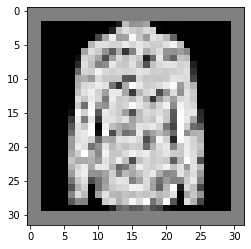

true label = y = 6

(x_min, x_max) =  (-1.0, 1.0)


In [3]:
idx = np.random.choice(len(train_dataset))

x = train_dataset[idx][0]
x = F.pad(x, (2 ,2, 2, 2), "constant", 0) # (left, right, top, bottom) padding to change size 28 --> 32=2**5
print(f'x of {x.shape} :')
plt.imshow(x[0], cmap='gray')
plt.show()

print(f'true label = y = {train_dataset[idx][1]}\n')

print(f'(x_min, x_max) =  {x.min().item(), round(x.max().item(),3)}')

# Define model (QNN), training and test loops


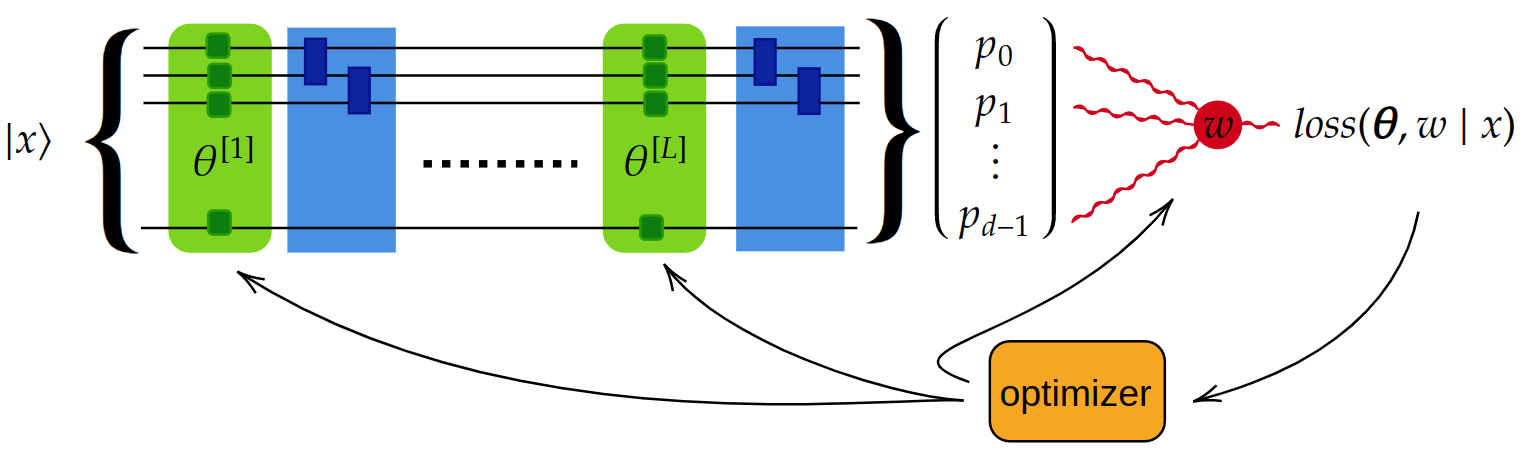

### QNN = parameterized quantum circuit (PQC)

A PQC is made of $L$ quantum layers. 
Here, each quantum layer $l$ has two parts: rotation $\text{R}_y(\theta^{[l]})$ in green and entangling $\text{CXs}$ in blue color.

-----------

__The rotation part__ is made of the tensor-product 
$\ \text{R}_y(\theta^{[l]}) = \displaystyle\bigotimes_{i} \text{R}_y(\theta^{[l]}_i)\ $
of single-qubit rotations (unitary gates) 
$\ \text{R}(\theta) = \cos(\theta) I + \texttt{i}\sin(\theta)\,Y$ around $y$-axis.
where $i\in\{1,\cdots,n\}$ is the qubit-index, the angles $\theta^{[l]}=(\theta^{[l]}_1,\cdots,\theta^{[l]}_n)$ of rotations are learnable parameters, and $n$ is the number of qubits.
$I$ is the Identity and $X, Y$ are the Pauli operators.
<br>


__The entangling part__ is made of the tensor-product 
$\text{CXs} = \displaystyle\bigotimes_{(i,j)} \text{CX}_{(i,j)}$
of two-qubit
$\text{CX}_{(i,j)} = |0\rangle_i\langle 0|\otimes I_j +|1\rangle_i\langle 1|\otimes X_j$ gates,
where $(i,j)$ represents the pair of control and target qubits $i$ and $j$, respectively.
This part will create entanglement between qubits and facilitate quantum information transfer between qubits. 
However, this part carries no learnable parameters.

-------------

__Input to the PQC__ is a $l_2$-normalized (quantum state) vector $|x\rangle$ of $2^n$ components. The ket $|x\rangle$ comes from the input vector $x$ after flattening a $32\times32$ image from the data.
Since $32\times32=:2^n=\text{dim}$ by definition, $n=10$.



__After the PQC__, we perform measurement on $|x,\Theta\rangle$ in the $z$-basis (computational-basis) and get a probability-vector $\textbf{p}(x,\Theta)=(p_0,\cdots,p_{\text{dim}})$. Then, we apply a linear layer in red color and obtain a $10$-component vector $\textbf{f}(\Theta, w|x)$. With $\textbf{f}$, we compute $loss(\Theta, w |x)$.
All the learnable parameters are made of $\Theta=\{\theta^{[1]}, \cdots, \theta^{[L]}\}$ associated with the quantum and $w$ associated with classical layer.



For details on the parameterized quantum circuit, see https://iopscience.iop.org/article/10.1088/2058-9565/ab4eb5
 


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"    # Get gpu or cpu device for training
print(f"Using {device} device\n")

#=====================================================================================


class QNN(torch.nn.Module):                              # Define model
    def __init__(self, n, L):                            # number of qubits = n, number of quantum layers = L
        super().__init__()
        
        self.flatten = nn.Flatten()
        
        angles = torch.empty((L, n), dtype=torch.float64)
        torch.nn.init.uniform_(angles, -0.01, 0.01)
        self.angles = torch.nn.Parameter(angles)                   # it makes angles learnable parameters
        
        
        self.linear = nn.Linear(2**n, 10)                          # classical linear layer
        

    def forward(self, x):
        x = F.pad(x, (2 ,2, 2, 2), "constant", 0)                  # (left, right, top, bottom) padding
        x = self.flatten(x)
        
        '''initializing parameterized quantum circuits (PQC)'''
        qc = quantum_circuit(num_qubits = n, state_vector = x.T)   # each column is a feature-vector of an example
        for l in range(L):
            qc.Ry_layer(self.angles[l].to(torch.cfloat))           # rotation part of lth quantum layer
            qc.cx_linear_layer()                                   # entangling part of lth quantum layer

        'after passing through the PQC, measurement on the output-ket in the computational basis'
        x = torch.real(qc.probabilities())               # each column is a probabilities-vector for an example 
                                                         # x.shape = (dim, batch size)
      
        x = self.linear(x.T)                             # x.shape = (batch size, 10),  classical linear layer
        
        return x  



Using cpu device



In [5]:

def performance_estimate(dataset, model, loss_fn, train_or_test):
    '''this function computes accuracy and loss of a model on the training or test set'''
    data_size = len(dataset)
    
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    num_batches = len(dataloader)
    
    model.eval()
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            accuracy += (pred.argmax(1) == y).sum().item()
            loss += loss_fn(pred, y).item()
    accuracy /= data_size                                            # accuracy lies in the interval [0, 1]  
    loss /= num_batches
    print(f"{train_or_test} accuracy: {round(accuracy, 3)},  {train_or_test} loss: {round(loss,3)}")
    return accuracy, loss




def one_epoch(model, loss_fn, optimizer, dataset, batch_size):
    
    A_train, L_train, A_test, L_test = [], [], [], []

    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        out = model(X)                             # Perform a single forward pass 
        loss = loss_fn(out, y)          
    
        optimizer.zero_grad()                      # Clear gradients
        loss.backward()                            # Derive gradients, backpropagation
        optimizer.step()                           # Update parameters based on gradients
        
    
        if batch % batch_size == 0: 
            #As training progress, computing and appending loss and accuracy of the model on train and test set
            accuracy_train, loss_train = performance_estimate(train_dataset, model, loss_fn, 'train')
            accuracy_test, loss_test = performance_estimate(test_dataset, model, loss_fn, 'test ')
            print()
            
            A_train.append(accuracy_train)        
            L_train.append(loss_train)
            A_test.append(accuracy_test)
            L_test.append(loss_test)
            
            #print(f"train loss: {round(loss,3)}")
    
    return A_train, L_train, A_test, L_test 
            

    
def training(dataset, batch_size, n, L, lr_, weight_decay_, epochs):
    
    model = QNN(n=n, L=L).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_, weight_decay=weight_decay_)
    
    A_Train, L_Train, A_Test, L_Test = [], [], [], []
    for t in range(epochs): 
        print(f"Epoch {t+1} ---------------------------------- \n")
        #As training progress, computing and appending loss and accuracy of the model on train and test set
        A_train, L_train, A_test, L_test = one_epoch(model, loss_fn, optimizer, dataset, batch_size)
        A_Train += A_train
        L_Train += L_train 
        A_Test += A_test
        L_Test += L_test
        
        #accuracy, loss = performance_estimate(test_dataset, model, loss_fn, 'test ')
    
    model_state_dict = model.state_dict()           # for saving or loading the trained model
    
    return A_Train, L_Train, A_Test, L_Test, model_state_dict
    

# training...

In [6]:
%%time

n = 10
dim = 2**n              # dimension of the n-qubit Hilbert space
L = 1

n_angs = n*L

print("number of qubits = ", n)
print("number of quantum layers = ", L)
print(f"number of angles (learnable parameters of quantum circuit) = {n_angs}\n ")

#--------------------------------------------------------------------------------------


batch_size = 64
print(f'batch_size = {batch_size}\n')


#----------------------------------------------------------------------------------


A_Train, L_Train, A_Test, L_Test, model_state_dict = training(train_dataset, batch_size=batch_size, n=n, L=L,
                                                              lr_=1e-3, weight_decay_=1e-8, epochs=1)


print(f' ~~~~~ training is done ~~~~~\n')

number of qubits =  10
number of quantum layers =  1
number of angles (learnable parameters of quantum circuit) = 10
 
batch_size = 64

Epoch 1 ---------------------------------- 

train accuracy: 0.209,  train loss: 2.295
test  accuracy: 0.209,  test  loss: 2.294

train accuracy: 0.691,  train loss: 1.028
test  accuracy: 0.683,  test  loss: 1.041

train accuracy: 0.766,  train loss: 0.712
test  accuracy: 0.753,  test  loss: 0.732

train accuracy: 0.789,  train loss: 0.614
test  accuracy: 0.78,  test  loss: 0.639

train accuracy: 0.795,  train loss: 0.572
test  accuracy: 0.788,  test  loss: 0.6

train accuracy: 0.804,  train loss: 0.557
test  accuracy: 0.795,  test  loss: 0.583

train accuracy: 0.817,  train loss: 0.512
test  accuracy: 0.81,  test  loss: 0.543

train accuracy: 0.824,  train loss: 0.497
test  accuracy: 0.813,  test  loss: 0.528

train accuracy: 0.831,  train loss: 0.478
test  accuracy: 0.818,  test  loss: 0.509

train accuracy: 0.831,  train loss: 0.478
test  accuracy: 

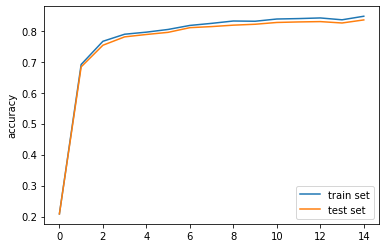

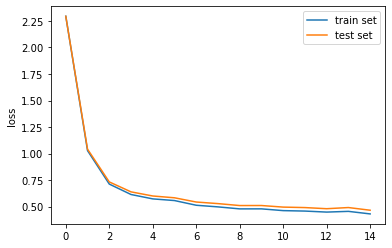

In [7]:
plt.plot(A_Train, label='train set')
plt.plot(A_Test, label='test set')
plt.ylabel('accuracy')
plt.legend()
plt.show()

plt.plot(L_Train, label='train set')
plt.plot(L_Test, label='test set')
plt.ylabel('loss')
plt.legend()
plt.show()

## save model

In [8]:
torch.save(model_state_dict, "model_MNIST_QNN.pth")

## load model

In [15]:
model = QNN(n=n, L=L).to(device)
model.load_state_dict(model_state_dict)

#model.load_state_dict(torch.load("model_MNIST_QNN.pth"))

<All keys matched successfully>

## predict test examples

x of torch.Size([1, 28, 28]) :


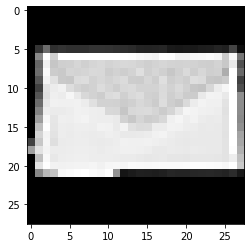

true label = y = 8

predicted label = 8



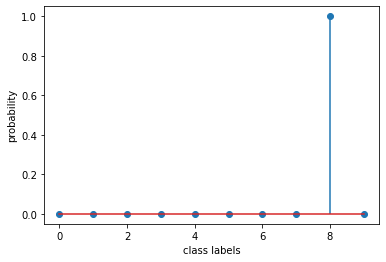

In [10]:
idx = np.random.choice(len(test_dataset))

x = test_dataset[idx][0]
print(f'x of {x.shape} :')
plt.imshow(x[0], cmap='gray')
plt.show()

print(f'true label = y = {test_dataset[idx][1]}\n')


out_ = model(x.view(1, 1, 28, 28)).detach().flatten()
prob = F.softmax(out_, dim=0)
pred = prob.argmax().item()
print(f'predicted label = {pred}\n')

plt.stem(np.arange(10), prob)
plt.ylabel('probability')
plt.xlabel('class labels')
plt.show()

$ $

$ $

## simplified training loop

In [12]:
def one_epoch_(model, loss_fn, optimizer, dataset, batch_size):
    
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        out = model(X)                             # Perform a single forward pass
        loss = loss_fn(out, y)          
    
        optimizer.zero_grad()                      # Clear gradients
        loss.backward()                            # Derive gradients, backpropagation
        optimizer.step()                           # Update parameters based on gradients
    
        if batch % batch_size == 0: 
            print(f"train loss: {round(loss.item(),3)}")


    
    
def training_(dataset, batch_size, n, L, lr_, weight_decay_, epochs):
    
    model = QNN(n=n, L=L).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr_, weight_decay=weight_decay_)
    
    for t in range(epochs): 
        print(f"Epoch {t+1} ---------------------------------- \n ")
        one_epoch_(model, loss_fn, optimizer, dataset, batch_size)
        
        #accuracy_train, loss_train = performance_estimate(train_dataset, model, loss_fn, 'train')
        #accuracy_test, loss_test = performance_estimate(test_dataset, model, loss_fn, 'test ')
        #print()

    
    model_state_dict = model.state_dict()
    return model_state_dict

    

In [13]:
%%time


batch_size = 64
print(f'batch_size = {batch_size}\n')

#----------------------------------------------------------------------------------

model_state_dict = training_(train_dataset, batch_size=batch_size, lr_=1e-2, n=n, L=L, 
                             weight_decay_=1e-3, epochs=1)

print()
print(f' ~~~~~ training is done ~~~~~\n')

batch_size = 64

Epoch 1 ---------------------------------- 
 
train loss: 2.387
train loss: 0.87
train loss: 0.611
train loss: 0.908
train loss: 0.754
train loss: 0.687
train loss: 0.511
train loss: 0.456
train loss: 0.501
train loss: 0.5
train loss: 0.671
train loss: 0.701
train loss: 0.576
train loss: 0.704
train loss: 0.333

 ~~~~~ training is done ~~~~~

CPU times: user 11min 20s, sys: 10.2 s, total: 11min 30s
Wall time: 2min 52s


In [16]:
%%time


model = QNN(n=n, L=L).to(device)
model.load_state_dict(model_state_dict)
loss_fn = nn.CrossEntropyLoss()


accuracy_train, loss_train = performance_estimate(train_dataset, model, loss_fn, 'train')
accuracy_test, loss_test = performance_estimate(test_dataset, model, loss_fn, 'test ')
print()



train accuracy: 0.831,  train loss: 0.509
test  accuracy: 0.817,  test  loss: 0.569

CPU times: user 9min 52s, sys: 252 ms, total: 9min 53s
Wall time: 2min 28s


# 